In [1]:
from PIL import Image
import numpy as np


FLAGS


In [2]:
CHECKONSTEP = True


blocks getting function


In [3]:
def getblocks(image: np.ndarray, blockshape: tuple, moveAxis: bool = True, info: bool = False, addChannel: bool = True) -> np.ndarray:
    '''
    takes the array of image in grey= 2D and in RGB = 3D
    takes the numpy array and converts it the the blocks in the fastest way
    '''
    if(info):
        print("Image Shape:", image.shape)
        print("Block Shape:", blockshape)

    oldshape = list(image.shape)
    if addChannel and len(image.shape) == 2:
        mode = "grey"
        image = image.reshape((*image.shape, 1))
    else:
        mode = "color"

    if addChannel:
        img_height, img_width, channels = image.shape
    else:
        img_height, img_width = image.shape

    tile_height, tile_width = blockshape

    if addChannel:
        shp = img_height//tile_height, tile_height, img_width//tile_width, tile_width, channels
    else:
        shp = img_height//tile_height, tile_height, img_width//tile_width, tile_width

    def printinfo():
        print("Old Shape:", oldshape)
        print("Image Shape:", image.shape)
        print("Block Shape:", blockshape)
        print("New Shape Initial:", shp)
        print("img_height % tile_height != 0 :", img_height % tile_height != 0)
        print("img_width % tile_width != 0 :", img_width % tile_width != 0)

    if img_height % tile_height != 0 or img_width % tile_width != 0:
        print("warning: Block size is not fit for the image!")
        printinfo()

    if(info):
        printinfo()

    tiled_array = image.reshape(shp)
    tiled_array = tiled_array.swapaxes(1, 2)

    if moveAxis:
        if(addChannel):
            tiled_array = tiled_array.reshape(-1,
                                              *(tile_height, tile_width, channels))
            tiled_array = np.moveaxis(tiled_array, source=len(
                tiled_array.shape)-1, destination=1)
        else:
            tiled_array = tiled_array.reshape(-1, *(tile_height, tile_width))

    return tiled_array


In [4]:
def combineBlocks(tiled_array: np.ndarray, imageshape: tuple, blockshape: tuple, movedAxis: bool = True, channel: bool = True) -> np.ndarray:

    if channel:
        if len(imageshape) == 2:
            mode = "grey"
            imageshape = *imageshape, 1
        else:
            mode = "color"

    if channel:
        img_height, img_width, channels = imageshape
    else:
        img_height, img_width = imageshape

    tile_height, tile_width = blockshape

    if movedAxis:
        image = tiled_array.copy()
        if(channel):
            image = image.reshape(img_height//tile_height, tile_height,
                                  img_width//tile_width, tile_width, channels)
            swapaxisShape = list(image.shape)
            swapaxisShape[1], swapaxisShape[2] = swapaxisShape[2], swapaxisShape[1]
            image = image.reshape(swapaxisShape)
            image = image.swapaxes(1, 2)
        else:
            f = image.reshape(img_height//tile_height, tile_height,
                              img_width//tile_width, tile_width)
            swapaxisShape = list(f.shape)
            swapaxisShape[1], swapaxisShape[2] = swapaxisShape[2], swapaxisShape[1]
            tmp = f.reshape(swapaxisShape)
            image = tmp.swapaxes(1, 2)
    else:
        image = tiled_array
        # IDK have completed this else case. Btw we aren't using this case lol :)

    return image.reshape(imageshape)


In [5]:
def printnd(arr: np.ndarray):
    print("Shape:", arr.shape)
    print("Strides:", arr.strides)
    print(arr)


PSNR function


In [6]:
from math import log10, sqrt


In [7]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
        # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr


importing image
e.g lena which is 512x512
importing as the grey image denoted by L flag


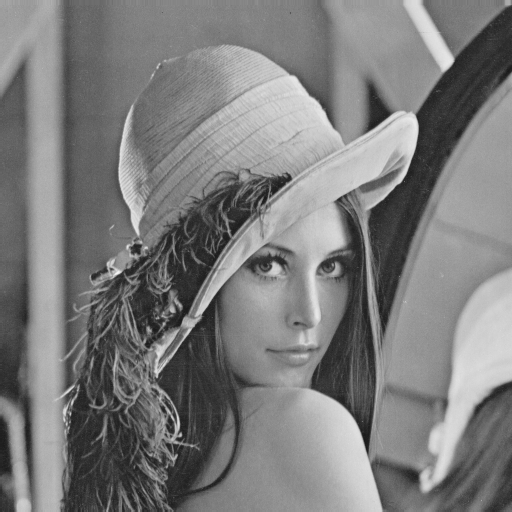

In [8]:
lena = Image.open("lena.gif").convert("L")
lena


In [9]:
lena.mode


'L'

converting to np array


In [10]:
img = np.array(lena)
imgSize = img.shape
M, N = img.shape
img.shape, img.strides, img


((512, 512),
 (512, 1),
 array([[162, 162, 162, ..., 170, 155, 128],
        [162, 162, 162, ..., 170, 155, 128],
        [162, 162, 162, ..., 170, 155, 128],
        ...,
        [ 43,  43,  50, ..., 104, 100,  98],
        [ 44,  44,  55, ..., 104, 105, 108],
        [ 44,  44,  55, ..., 104, 105, 108]], dtype=uint8))

making 16 main blocks
size of single main block S= M/sqrt(16) X T=N/sqrt(16)
e.g for lena the 512x512 the partner blocks size would be 16 blocks each with size (512x512)/(4x4) = 128x128


In [11]:
PSNR(img,img)

100

In [12]:
mainblockSize = (int(imgSize[0]/4), int(imgSize[1]/4))
mainblocks = getblocks(img.copy(), mainblockSize, info=True)
mainblocks.shape, mainblocks.strides, mainblocks


Image Shape: (512, 512)
Block Shape: (128, 128)
Old Shape: [512, 512]
Image Shape: (512, 512, 1)
Block Shape: (128, 128)
New Shape Initial: (4, 128, 4, 128, 1)
img_height % tile_height != 0 : False
img_width % tile_width != 0 : False


((16, 1, 128, 128),
 (16384, 1, 128, 1),
 array([[[[162, 162, 162, ..., 127, 132, 131],
          [162, 162, 162, ..., 127, 132, 131],
          [162, 162, 162, ..., 127, 132, 131],
          ...,
          [ 97,  97,  92, ..., 221, 211, 201],
          [ 90,  90,  93, ..., 217, 210, 191],
          [ 95,  95,  92, ..., 215, 207, 192]]],
 
 
        [[[132, 129, 135, ..., 129, 133, 138],
          [132, 129, 135, ..., 129, 133, 138],
          [132, 129, 135, ..., 129, 133, 138],
          ...,
          [188, 172, 146, ..., 184, 188, 194],
          [184, 178, 141, ..., 187, 185, 188],
          [188, 162, 162, ..., 179, 185, 183]]],
 
 
        [[[138, 142, 134, ..., 154, 152, 152],
          [138, 142, 134, ..., 154, 152, 152],
          [138, 142, 134, ..., 154, 152, 152],
          ...,
          [191, 186, 183, ..., 214, 218, 210],
          [196, 195, 186, ..., 218, 210, 202],
          [185, 196, 194, ..., 205, 192, 172]]],
 
 
        ...,
 
 
        [[[ 86, 107, 121, ...,  7

here the main blocks are like this index.
1st index is the block number.
2nd index is the channel (RGB) or 0 in Grey.
3rd and 4th are for indexing the block.


converting back and checking


In [13]:

mainblocks.shape, img.shape


((16, 1, 128, 128), (512, 512))

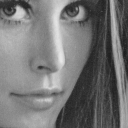

In [14]:

Image.fromarray(mainblocks[10][0], 'L')


In [15]:

combinedImg = combineBlocks(mainblocks, imgSize, mainblockSize)
combinedImg.shape, combinedImg
combinedImg = combinedImg.reshape(imgSize)
combinedImg.shape, combinedImg


((512, 512),
 array([[162, 162, 162, ..., 170, 155, 128],
        [162, 162, 162, ..., 170, 155, 128],
        [162, 162, 162, ..., 170, 155, 128],
        ...,
        [ 43,  43,  50, ..., 104, 100,  98],
        [ 44,  44,  55, ..., 104, 105, 108],
        [ 44,  44,  55, ..., 104, 105, 108]], dtype=uint8))

In [16]:

(combinedImg == img).all()


True

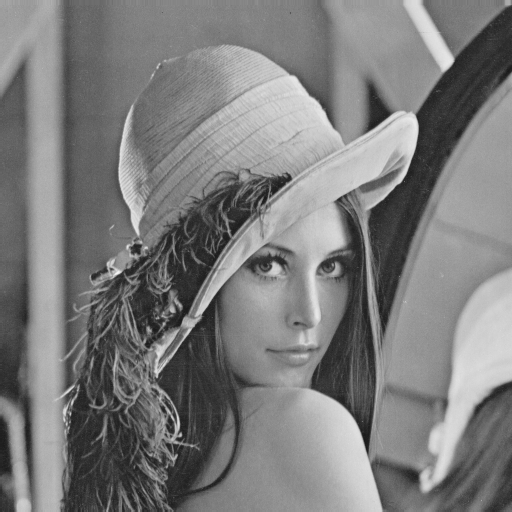

In [17]:

Image.fromarray(combinedImg, 'L')


In [18]:
PSNR(img,combinedImg)


100

lookup table


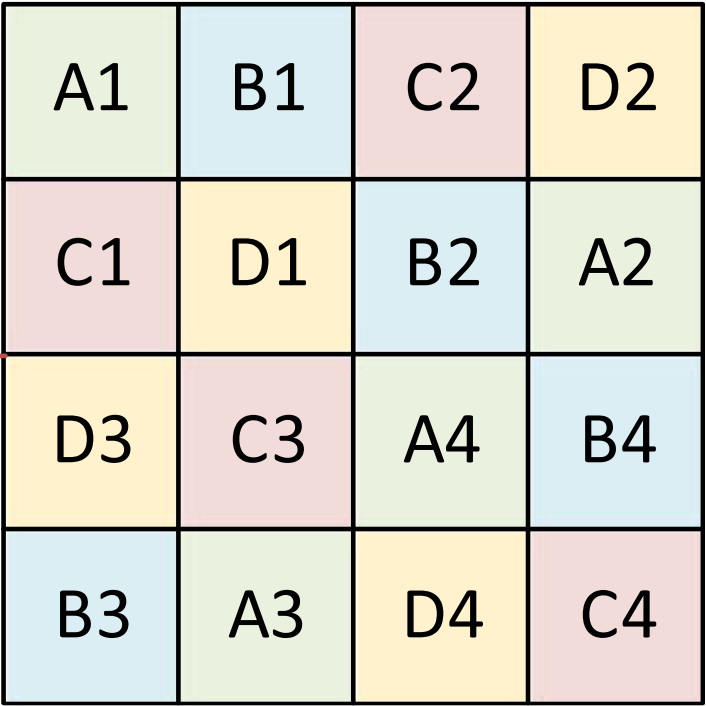

In [19]:
Image.open("lookup.png")


In [20]:
lookup = np.array([[0, 7, 13, 10],
                  [1, 6, 12, 11],
                  [4, 2, 9, 15],
                  [5, 3, 8, 14]], dtype=np.uint8)
lookup


array([[ 0,  7, 13, 10],
       [ 1,  6, 12, 11],
       [ 4,  2,  9, 15],
       [ 5,  3,  8, 14]], dtype=uint8)

here the every row represents the partner blocks
e.g
A1 will be lookup[0][0].
A2 will be lookup[0][2].
D2 will be lookup[3][2].


Step3
Ab har main block ko divide karo k 4x4 k block ban jain
numberOfBlocks=(SxT)/(4x4)
e.g 128x128/4x4 = 1024


In [21]:
avgblocksSize = (4, 4)
averages = np.zeros((16, int((mainblockSize[0]*mainblockSize[1]) /
                             (avgblocksSize[0]*avgblocksSize[1]))), dtype=np.uint8)
# 4 indicatior A,B,C,D, 4 blocks of A, then the 4x4 Blocks which have count = (SxT)/(4x4), e.g 1024


storing the averages of A, B, C, D


In [22]:
lookup


array([[ 0,  7, 13, 10],
       [ 1,  6, 12, 11],
       [ 4,  2,  9, 15],
       [ 5,  3,  8, 14]], dtype=uint8)

In [23]:
for partner in lookup:  # A,B,C,D
    for id in partner:  # A1,A2,A3.....D4 etc
        averages[id] = getblocks(mainblocks[id][0].copy(), avgblocksSize,
                                 info=False, addChannel=False).mean((1, 2))
averages.shape, averages


((16, 1024),
 array([[161, 160, 162, ..., 114, 106, 200],
        [131, 129, 134, ..., 190, 185, 186],
        [136, 129, 132, ...,  47, 146, 206],
        ...,
        [101, 110, 111, ..., 136, 136, 133],
        [ 89, 100, 113, ..., 208, 211, 165],
        [126, 121, 131, ...,  68,  90, 102]], dtype=uint8))

array([[162, 162, 162, 161],
       [162, 162, 162, 161],
       [162, 162, 162, 161],
       [162, 162, 162, 161]], dtype=uint8)
this will give you the avg 161. But it sould be 162 as it's dominant. Minor improvemnt reuqired


now we have average of every mainblock according to 4x4. Which in total are 1024


time to convert them into the binary


In [24]:
averageBits = np.unpackbits(averages, axis=1)
averageBits.shape, averageBits


((16, 8192),
 array([[1, 0, 1, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 1, 1, 0],
        ...,
        [0, 1, 1, ..., 1, 0, 1],
        [0, 1, 0, ..., 1, 0, 1],
        [0, 1, 1, ..., 1, 1, 0]], dtype=uint8))

merging partner blocks average to make the recovery bits


In [25]:
recoveryBits = np.zeros(
    (averageBits.shape[0], averageBits.shape[1]*3), dtype=np.uint8)
for partner in lookup:  # A,B,C,D
    for id in partner:  # A1,A2,A3.....D4 etc
        recoveryBits[id] = np.concatenate(
            [averageBits[i] for i in partner if i != id])

recoveryBits.shape, recoveryBits


((16, 24576),
 array([[1, 1, 0, ..., 1, 1, 0],
        [1, 0, 1, ..., 1, 1, 0],
        [0, 1, 0, ..., 1, 1, 0],
        ...,
        [1, 0, 1, ..., 1, 1, 0],
        [1, 0, 0, ..., 1, 0, 1],
        [0, 1, 0, ..., 1, 1, 1]], dtype=uint8))

password or key generation


In [26]:
import hashlib


In [27]:
# password or key
password = "this is my password"
key = [x for x in hashlib.sha256(password.encode()).digest()]
len(key)


32

permuttaion or shuffling


In [28]:
for i in range(recoveryBits.shape[0]):
    np.random.RandomState(seed=key).shuffle(recoveryBits[i])

recoveryBits.shape, recoveryBits


((16, 24576),
 array([[0, 1, 1, ..., 1, 1, 1],
        [1, 1, 0, ..., 1, 0, 0],
        [0, 1, 0, ..., 1, 0, 1],
        ...,
        [1, 1, 1, ..., 1, 0, 1],
        [0, 1, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 1, 0, 1]], dtype=uint8))

Recovery bits creation completed
Now we need to make the space to put these recovery bits


### Making 16x16 for Step 8

Dividing the main blocks to 16x16 blocks
Total blocks = SxT/16x16 = 128x128/16x16 = 64 Blocks


In [29]:
mainblocks.shape


(16, 1, 128, 128)

In [30]:
blocks16x16Size = (16, 16)
# reshaping because we needed that shape
blocks16x16 = mainblocks.copy().reshape(
    *mainblocks.shape[:-2],
    int((mainblockSize[0]*mainblockSize[1]) /
        (blocks16x16Size[0]*blocks16x16Size[1])),
    blocks16x16Size[0], blocks16x16Size[1]).copy()

blocks16x16Size, blocks16x16.shape, blocks16x16.strides, blocks16x16


((16, 16),
 (16, 1, 64, 16, 16),
 (16384, 16384, 256, 16, 1),
 array([[[[[162, 162, 162, ..., 163, 160, 155],
           [157, 156, 161, ..., 154, 154, 156],
           [154, 158, 155, ..., 175, 173, 170],
           ...,
           [110, 108, 107, ..., 109, 107, 109],
           [109, 110, 110, ..., 118, 121, 119],
           [112, 122, 121, ..., 127, 132, 131]],
 
          [[162, 162, 162, ..., 163, 160, 155],
           [157, 156, 161, ..., 154, 154, 156],
           [154, 158, 155, ..., 175, 173, 170],
           ...,
           [110, 108, 107, ..., 109, 107, 109],
           [109, 110, 110, ..., 118, 121, 119],
           [112, 122, 121, ..., 127, 132, 131]],
 
          [[162, 162, 162, ..., 163, 160, 155],
           [157, 156, 161, ..., 154, 154, 156],
           [154, 158, 155, ..., 175, 173, 170],
           ...,
           [105, 107, 108, ..., 108, 105, 102],
           [108, 104, 111, ..., 115, 118, 120],
           [120, 122, 119, ..., 124, 125, 124]],
 
          ...,
 


In [31]:
for i in range(mainblocks.shape[0]):
    blocks16x16[i][0] = getblocks(mainblocks[i][0].copy(), blocks16x16Size,
                                  info=False, addChannel=False)

blocks16x16.shape, blocks16x16.strides, blocks16x16


((16, 1, 64, 16, 16),
 (16384, 16384, 256, 16, 1),
 array([[[[[162, 162, 162, ..., 163, 160, 155],
           [162, 162, 162, ..., 163, 160, 155],
           [162, 162, 162, ..., 163, 160, 155],
           ...,
           [157, 157, 157, ..., 155, 154, 160],
           [158, 158, 159, ..., 156, 156, 155],
           [158, 158, 159, ..., 156, 154, 171]],
 
          [[157, 156, 161, ..., 154, 154, 156],
           [157, 156, 161, ..., 154, 154, 156],
           [157, 156, 161, ..., 154, 154, 156],
           ...,
           [159, 155, 158, ..., 157, 157, 154],
           [155, 159, 155, ..., 153, 156, 157],
           [157, 155, 157, ..., 157, 157, 160]],
 
          [[154, 158, 155, ..., 175, 173, 170],
           [154, 158, 155, ..., 175, 173, 170],
           [154, 158, 155, ..., 175, 173, 170],
           ...,
           [157, 159, 159, ..., 169, 168, 169],
           [160, 160, 165, ..., 171, 169, 166],
           [164, 162, 163, ..., 167, 166, 169]],
 
          ...,
 
          [

combinign for checking


In [32]:
# if CHECKONSTEP:
blocks16x16.shape, mainblocks.shape, img.shape


((16, 1, 64, 16, 16), (16, 1, 128, 128), (512, 512))

In [33]:
# if CHECKONSTEP:
Image.fromarray(blocks16x16[10][0][0], 'L')


In [34]:
# if CHECKONSTEP:
combinedMainBlocks = mainblocks.copy()


In [35]:
# if CHECKONSTEP:
for i in range(combinedMainBlocks.shape[0]):
    combinedMainBlocks[i][0] = combineBlocks(
        blocks16x16[i][0].copy(), (128, 128), blockshape=(16, 16), channel=False)

combinedMainBlocks.shape, combinedMainBlocks


((16, 1, 128, 128),
 array([[[[162, 162, 162, ..., 127, 132, 131],
          [162, 162, 162, ..., 127, 132, 131],
          [162, 162, 162, ..., 127, 132, 131],
          ...,
          [ 97,  97,  92, ..., 221, 211, 201],
          [ 90,  90,  93, ..., 217, 210, 191],
          [ 95,  95,  92, ..., 215, 207, 192]]],
 
 
        [[[132, 129, 135, ..., 129, 133, 138],
          [132, 129, 135, ..., 129, 133, 138],
          [132, 129, 135, ..., 129, 133, 138],
          ...,
          [188, 172, 146, ..., 184, 188, 194],
          [184, 178, 141, ..., 187, 185, 188],
          [188, 162, 162, ..., 179, 185, 183]]],
 
 
        [[[138, 142, 134, ..., 154, 152, 152],
          [138, 142, 134, ..., 154, 152, 152],
          [138, 142, 134, ..., 154, 152, 152],
          ...,
          [191, 186, 183, ..., 214, 218, 210],
          [196, 195, 186, ..., 218, 210, 202],
          [185, 196, 194, ..., 205, 192, 172]]],
 
 
        ...,
 
 
        [[[ 86, 107, 121, ...,  71,  69,  68],
       

In [36]:
# if CHECKONSTEP:
combinedMainBlocks.shape


(16, 1, 128, 128)

In [37]:
# if CHECKONSTEP:
(combinedMainBlocks == mainblocks).all()


True

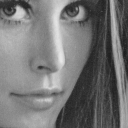

In [38]:
# if CHECKONSTEP:
Image.fromarray(mainblocks[10][0], 'L')


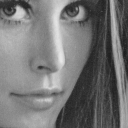

In [39]:
# if CHECKONSTEP:
Image.fromarray(combinedMainBlocks[10][0], 'L')


In [40]:
# if CHECKONSTEP:
combinedImg = combineBlocks(
    combinedMainBlocks.copy(), imgSize, mainblockSize)
combinedImg.shape, combinedImg
combinedImg = combinedImg.reshape(imgSize)
combinedImg.shape, combinedImg


((512, 512),
 array([[162, 162, 162, ..., 170, 155, 128],
        [162, 162, 162, ..., 170, 155, 128],
        [162, 162, 162, ..., 170, 155, 128],
        ...,
        [ 43,  43,  50, ..., 104, 100,  98],
        [ 44,  44,  55, ..., 104, 105, 108],
        [ 44,  44,  55, ..., 104, 105, 108]], dtype=uint8))

In [41]:
# if CHECKONSTEP:
(combinedImg == img).all()


True

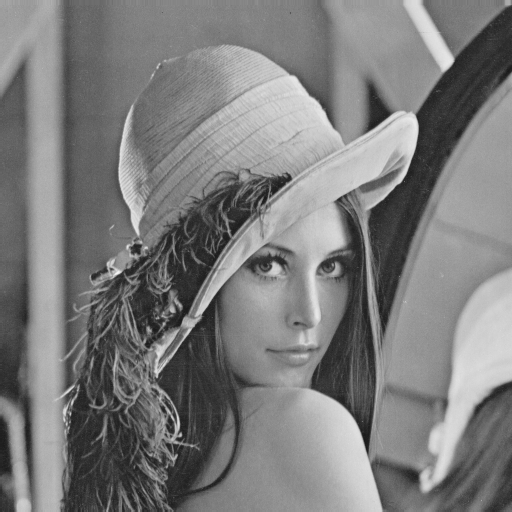

In [42]:
# if CHECKONSTEP:
Image.fromarray(combinedImg, 'L')


In [43]:
PSNR(img,combinedImg)


100

### Making 8x8 blocks of those 16x16 Step 9


In [44]:
blocks16x16.shape


(16, 1, 64, 16, 16)

In [45]:
blocks8x8Size = (8, 8)
# reshaping because we needed that shape
blocks8x8 = blocks16x16.copy().reshape(
    *blocks16x16.shape[:-2],
    int((blocks16x16Size[0]*blocks16x16Size[1]) /
        (blocks8x8Size[0]*blocks8x8Size[1])),
    blocks8x8Size[0], blocks8x8Size[1])

blocks8x8Size, blocks8x8.shape, blocks8x8.strides, blocks8x8


((8, 8),
 (16, 1, 64, 4, 8, 8),
 (16384, 16384, 256, 64, 8, 1),
 array([[[[[[162, 162, 162, ..., 157, 163, 161],
            [166, 162, 162, ..., 163, 160, 155],
            [162, 162, 162, ..., 157, 163, 161],
            ...,
            [166, 162, 162, ..., 163, 160, 155],
            [162, 162, 162, ..., 157, 163, 161],
            [166, 162, 162, ..., 163, 160, 155]],
 
           [[162, 162, 162, ..., 157, 163, 161],
            [166, 162, 162, ..., 163, 160, 155],
            [164, 164, 158, ..., 159, 159, 160],
            ...,
            [159, 163, 158, ..., 155, 156, 152],
            [159, 159, 155, ..., 159, 156, 157],
            [159, 162, 162, ..., 153, 153, 151]],
 
           [[155, 155, 158, ..., 160, 157, 157],
            [163, 157, 159, ..., 154, 156, 157],
            [155, 155, 157, ..., 154, 155, 157],
            ...,
            [159, 159, 157, ..., 154, 158, 154],
            [156, 156, 156, ..., 155, 150, 148],
            [160, 159, 158, ..., 155, 157, 158

In [46]:
blocks8x8.shape


(16, 1, 64, 4, 8, 8)

In [47]:
blocks16x16.shape, blocks8x8.shape


((16, 1, 64, 16, 16), (16, 1, 64, 4, 8, 8))

In [48]:
for i in range(blocks16x16.shape[0]):
    for j in range(blocks16x16.shape[2]):
        blocks8x8[i][0][j] = getblocks(blocks16x16[i][0][j].copy(), blocks8x8Size,
                                       info=False, addChannel=False)

blocks8x8.shape, blocks8x8.strides, blocks8x8


((16, 1, 64, 4, 8, 8),
 (16384, 16384, 256, 64, 8, 1),
 array([[[[[[162, 162, 162, ..., 157, 163, 161],
            [162, 162, 162, ..., 157, 163, 161],
            [162, 162, 162, ..., 157, 163, 161],
            ...,
            [164, 164, 158, ..., 159, 159, 160],
            [160, 160, 163, ..., 162, 159, 156],
            [159, 159, 155, ..., 159, 156, 157]],
 
           [[166, 162, 162, ..., 163, 160, 155],
            [166, 162, 162, ..., 163, 160, 155],
            [166, 162, 162, ..., 163, 160, 155],
            ...,
            [161, 160, 155, ..., 154, 156, 154],
            [159, 163, 158, ..., 155, 156, 152],
            [159, 162, 162, ..., 153, 153, 151]],
 
           [[155, 155, 158, ..., 160, 157, 157],
            [155, 155, 157, ..., 154, 155, 157],
            [156, 156, 156, ..., 155, 155, 152],
            ...,
            [157, 157, 157, ..., 157, 156, 156],
            [158, 158, 159, ..., 158, 158, 156],
            [158, 158, 159, ..., 158, 157, 154]],
 
   

combining and checking


In [49]:
blocks8x8.shape, blocks16x16.shape, mainblocks.shape, img.shape


((16, 1, 64, 4, 8, 8), (16, 1, 64, 16, 16), (16, 1, 128, 128), (512, 512))

In [50]:
Image.fromarray(blocks8x8[10][0][0][0], 'L')


In [51]:
Image.fromarray(blocks8x8[10][0][0][1], 'L')


In [52]:
combined16x16 = blocks16x16.copy()


In [53]:
combined16x16.shape, blocks8x8.shape


((16, 1, 64, 16, 16), (16, 1, 64, 4, 8, 8))

In [54]:
for i in range(combined16x16.shape[0]):
    for j in range(combined16x16.shape[2]):
        combined16x16[i][0][j] = combineBlocks(blocks8x8[i][0][j].copy(), imageshape=(
            16, 16), blockshape=(8, 8), channel=False)
combined16x16.shape, combined16x16.strides, combined16x16


((16, 1, 64, 16, 16),
 (16384, 16384, 256, 16, 1),
 array([[[[[162, 162, 162, ..., 163, 160, 155],
           [162, 162, 162, ..., 163, 160, 155],
           [162, 162, 162, ..., 163, 160, 155],
           ...,
           [157, 157, 157, ..., 155, 154, 160],
           [158, 158, 159, ..., 156, 156, 155],
           [158, 158, 159, ..., 156, 154, 171]],
 
          [[157, 156, 161, ..., 154, 154, 156],
           [157, 156, 161, ..., 154, 154, 156],
           [157, 156, 161, ..., 154, 154, 156],
           ...,
           [159, 155, 158, ..., 157, 157, 154],
           [155, 159, 155, ..., 153, 156, 157],
           [157, 155, 157, ..., 157, 157, 160]],
 
          [[154, 158, 155, ..., 175, 173, 170],
           [154, 158, 155, ..., 175, 173, 170],
           [154, 158, 155, ..., 175, 173, 170],
           ...,
           [157, 159, 159, ..., 169, 168, 169],
           [160, 160, 165, ..., 171, 169, 166],
           [164, 162, 163, ..., 167, 166, 169]],
 
          ...,
 
          [

In [55]:
Image.fromarray(combined16x16[10][0][0], 'L')


In [56]:
Image.fromarray(blocks16x16[10][0][0], 'L')


In [57]:
(combined16x16 == blocks16x16).all()


True

In [58]:
combinedMainBlocks = mainblocks.copy()


In [59]:
for i in range(combinedMainBlocks.shape[0]):
    combinedMainBlocks[i][0] = combineBlocks(
        combined16x16[i][0], (128, 128), blockshape=(16, 16), channel=False)

combinedMainBlocks.shape, combinedMainBlocks


((16, 1, 128, 128),
 array([[[[162, 162, 162, ..., 127, 132, 131],
          [162, 162, 162, ..., 127, 132, 131],
          [162, 162, 162, ..., 127, 132, 131],
          ...,
          [ 97,  97,  92, ..., 221, 211, 201],
          [ 90,  90,  93, ..., 217, 210, 191],
          [ 95,  95,  92, ..., 215, 207, 192]]],
 
 
        [[[132, 129, 135, ..., 129, 133, 138],
          [132, 129, 135, ..., 129, 133, 138],
          [132, 129, 135, ..., 129, 133, 138],
          ...,
          [188, 172, 146, ..., 184, 188, 194],
          [184, 178, 141, ..., 187, 185, 188],
          [188, 162, 162, ..., 179, 185, 183]]],
 
 
        [[[138, 142, 134, ..., 154, 152, 152],
          [138, 142, 134, ..., 154, 152, 152],
          [138, 142, 134, ..., 154, 152, 152],
          ...,
          [191, 186, 183, ..., 214, 218, 210],
          [196, 195, 186, ..., 218, 210, 202],
          [185, 196, 194, ..., 205, 192, 172]]],
 
 
        ...,
 
 
        [[[ 86, 107, 121, ...,  71,  69,  68],
       

In [60]:
combinedMainBlocks.shape


(16, 1, 128, 128)

In [61]:
(combinedMainBlocks == mainblocks).all()


True

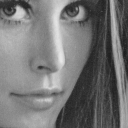

In [62]:
Image.fromarray(mainblocks[10][0], 'L')


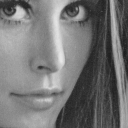

In [63]:
Image.fromarray(combinedMainBlocks[10][0], 'L')


In [64]:
combinedImg = combineBlocks(combinedMainBlocks.copy(), imgSize, mainblockSize)
combinedImg.shape, combinedImg
combinedImg = combinedImg.reshape(imgSize)
combinedImg.shape, combinedImg


((512, 512),
 array([[162, 162, 162, ..., 170, 155, 128],
        [162, 162, 162, ..., 170, 155, 128],
        [162, 162, 162, ..., 170, 155, 128],
        ...,
        [ 43,  43,  50, ..., 104, 100,  98],
        [ 44,  44,  55, ..., 104, 105, 108],
        [ 44,  44,  55, ..., 104, 105, 108]], dtype=uint8))

In [65]:
(combinedImg == img).all()


True

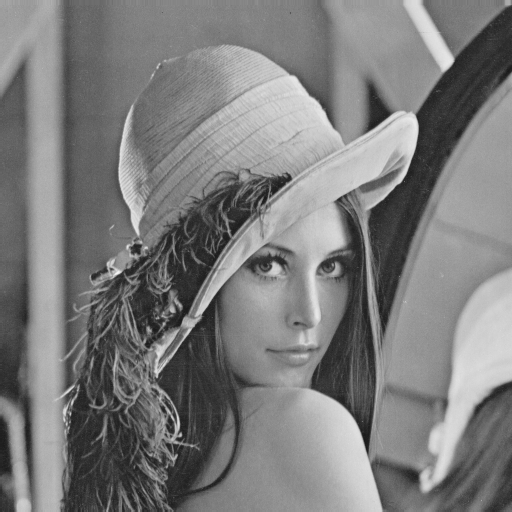

In [66]:
Image.fromarray(combinedImg, 'L')


In [67]:
PSNR(img,combinedImg)


100

Now put the recovery bit in the first and second LSB of blocks4x4


In [68]:
blocks8x8.shape


(16, 1, 64, 4, 8, 8)

In [69]:
recoveryBits.reshape(recoveryBits.shape[0], int(
    recoveryBits.shape[1]//2), 2).shape


(16, 12288, 2)

In [70]:
recoveryBits[0]


array([0, 1, 1, ..., 1, 1, 1], dtype=uint8)

In [71]:
recoveryBits.shape, blocks8x8.shape[2]*3*8*8*2


((16, 24576), 24576)

In [72]:
blocks8x8[:, 0, :, :3, :, :].shape, blocks8x8[:, 0, :, :3, :,
                                              :][0].shape, blocks8x8[:, 0, :, :3, :, :][0].flatten().shape


((16, 64, 3, 8, 8), (64, 3, 8, 8), (12288,))

updating the lsb


In [73]:
def set_bit(value, index, x):
    # """Set the index:th bit of v to 1 if x is truthy, else to 0, and return the new value."""
    # mask = 1 << index   # Compute mask, an integer with just bit 'index' set.
    # # Clear the bit indicated by the mask (if x is False)
    # value &= ~mask
    # if x:
    #     # If x was True, set the bit indicated by the mask.
    #     value |= mask
    # return value            # Return the result, we're done.
    def set_bit2(value, bit):
        return value | (1 << bit)

    def clear_bit(value, bit):
        return value & ~(1 << bit)

    if x:
        return set_bit2(value, index)
    else:
        return clear_bit(value, index)


In [74]:
set_bit(2, 3, 0), set_bit(2, 2, 1)
#(0, 6)


(2, 6)

In [75]:
bits = recoveryBits.reshape(
    recoveryBits.shape[0], int(recoveryBits.shape[1]//2), 2)
for i in range(blocks8x8[:, 0].shape[0]):
    for j in range(blocks8x8[:, 0].shape[1]):
        number = blocks8x8[i, 0, :, :3, :, :].flat[j]
        blocks8x8[i, 0, :, :3, :, :].flat[j] = set_bit(
            set_bit(number, 0, bits[i][j][0]), 1, bits[i][j][1])

# for mainblock, blockbits in zip(blocks8x8[:, 0, :, :3, :, :], recoveryBits.reshape(recoveryBits.shape[0], int(recoveryBits.shape[1]//2), 2)):
#     for number, bits in zip(mainblock.flat, blockbits):
#         # print(number, bits)
#         number = set_bit(set_bit(number, 0, bits[0]), 1, bits[1])

blocks8x8.shape, blocks8x8.strides, blocks8x8


((16, 1, 64, 4, 8, 8),
 (16384, 16384, 256, 64, 8, 1),
 array([[[[[[162, 161, 163, ..., 157, 160, 160],
            [162, 161, 163, ..., 158, 160, 161],
            [160, 161, 160, ..., 156, 163, 160],
            ...,
            [165, 164, 156, ..., 158, 159, 160],
            [162, 163, 160, ..., 163, 159, 158],
            [157, 158, 152, ..., 158, 156, 157]],
 
           [[166, 162, 162, ..., 163, 160, 155],
            [166, 162, 162, ..., 163, 160, 155],
            [166, 162, 162, ..., 163, 160, 155],
            ...,
            [161, 160, 155, ..., 154, 156, 154],
            [159, 163, 158, ..., 155, 156, 152],
            [159, 162, 162, ..., 153, 153, 151]],
 
           [[155, 155, 158, ..., 160, 157, 157],
            [155, 155, 157, ..., 154, 155, 157],
            [156, 156, 156, ..., 155, 155, 152],
            ...,
            [157, 157, 157, ..., 157, 156, 156],
            [158, 158, 159, ..., 158, 158, 156],
            [158, 158, 159, ..., 158, 157, 154]],
 
   

### get authenticaction bits


getting hash of four blocks with lsb 0


In [76]:
def set_lsb_zero(num):
    '''
    Clearing the first two LSB
    '''
    return set_bit(set_bit(num, 0, 0), 1, 0)


def hash_block(data: np.ndarray, key: str = None, digest_size=28, extras=[]):
    if data.shape != (4, 8, 8):
        print(f"Warning! given size {data.shape} instead of (4, 8, 8)")
    local = data.copy().astype(np.int8)  # copying to avoid overighting lsb
    local[-1] = set_lsb_zero(local[-1])  # setting last 8x8 blocks lsb zero
    if key is None:
        h = hashlib.blake2b(digest_size=digest_size)
    else:
        h = hashlib.blake2b(key=key.encode())
    h.update(local.data)
    for extra in extras:
        h.update(extra.encode())
    return h


In [77]:
blocks8x8[:, 0].shape, blocks8x8[:,
                                 0][0].shape, blocks8x8[:, 0][0].flatten().shape


((16, 64, 4, 8, 8), (64, 4, 8, 8), (16384,))

In [78]:
# hashes = np.zeros(blocks8x8[:, 0].shape[:2], dtype=str)
# hashes.shape, hashes


In [79]:
# def hexToDec(hexStr):
#     return np.fromiter((int(x, 16) for x in hexStr), dtype=np.uint8)


# def binToNp(binStr):
#     return np.frombuffer(binStr, dtype=np.uint8)


# has = hash_block(blocks8x8[0, 0, 1])

# print(has, has.hexdigest(), len(has.digest()))
# dec=binToNp(has.digest())
# dec.shape


In [80]:
# num="A"
# int(num,16), ord(num)


In [81]:
# binToNp(b'\x')


In [82]:
# hashes[0]='ashdadka'
# hashes


In [83]:
# type(hashlib.sha256("basd".encode()).hexdigest())


In [84]:
# hash_block(blocks8x8[0, 0, 0], digest_size=32)


In [85]:
# for i in range(blocks8x8[:, 0].shape[0]):
#     for j in range(blocks8x8[:, 0].shape[1]):
#         hashes[i][j] = hash_block(
#             blocks8x8[i, 0, j], digest_size=32)


# hashes.shape,hashes[0][0], hashes


### Now to combine the blocks back to Image


In [86]:
blocks8x8.shape, blocks16x16.shape, mainblocks.shape, img.shape


((16, 1, 64, 4, 8, 8), (16, 1, 64, 16, 16), (16, 1, 128, 128), (512, 512))

first merge the 8x8


In [87]:
Image.fromarray(blocks8x8[10][0][0][0], 'L')


In [88]:
Image.fromarray(blocks8x8[10][0][0][1], 'L')


In [89]:
combined16x16 = blocks16x16.copy()


In [90]:
combined16x16.shape, blocks8x8.shape


((16, 1, 64, 16, 16), (16, 1, 64, 4, 8, 8))

In [91]:
for i in range(combined16x16.shape[0]):
    for j in range(combined16x16.shape[2]):
        combined16x16[i][0][j] = combineBlocks(blocks8x8[i][0][j].copy(), imageshape=(
            16, 16), blockshape=(8, 8), channel=False)
combined16x16.shape, combined16x16.strides, combined16x16


((16, 1, 64, 16, 16),
 (16384, 16384, 256, 16, 1),
 array([[[[[162, 161, 163, ..., 163, 160, 155],
           [162, 161, 163, ..., 163, 160, 155],
           [160, 161, 160, ..., 163, 160, 155],
           ...,
           [157, 157, 157, ..., 155, 154, 160],
           [158, 158, 159, ..., 156, 156, 155],
           [158, 158, 159, ..., 156, 154, 171]],
 
          [[157, 156, 161, ..., 154, 154, 156],
           [157, 156, 161, ..., 154, 154, 156],
           [157, 156, 161, ..., 154, 154, 156],
           ...,
           [159, 155, 158, ..., 157, 157, 154],
           [155, 159, 155, ..., 153, 156, 157],
           [157, 155, 157, ..., 157, 157, 160]],
 
          [[154, 158, 155, ..., 175, 173, 170],
           [154, 158, 155, ..., 175, 173, 170],
           [154, 158, 155, ..., 175, 173, 170],
           ...,
           [157, 159, 159, ..., 169, 168, 169],
           [160, 160, 165, ..., 171, 169, 166],
           [164, 162, 163, ..., 167, 166, 169]],
 
          ...,
 
          [

In [92]:
Image.fromarray(combined16x16[10][0][0], 'L')


In [93]:
Image.fromarray(blocks16x16[10][0][0], 'L')


In [94]:
(combined16x16 == blocks16x16).all()


False

merging 16x16 to 128x128


In [95]:
mainblocks.shape, blocks16x16.shape


((16, 1, 128, 128), (16, 1, 64, 16, 16))

In [96]:
combinedMainBlocks = mainblocks.copy()


In [97]:
for i in range(combinedMainBlocks.shape[0]):
    combinedMainBlocks[i][0] = combineBlocks(
        combined16x16[i][0], (128, 128), blockshape=(16, 16), channel=False)

combinedMainBlocks.shape, combinedMainBlocks


((16, 1, 128, 128),
 array([[[[162, 161, 163, ..., 127, 132, 131],
          [162, 161, 163, ..., 127, 132, 131],
          [160, 161, 160, ..., 127, 132, 131],
          ...,
          [ 97,  97,  92, ..., 221, 211, 201],
          [ 90,  90,  93, ..., 217, 210, 191],
          [ 95,  95,  92, ..., 215, 207, 192]]],
 
 
        [[[135, 130, 135, ..., 129, 133, 138],
          [135, 130, 133, ..., 129, 133, 138],
          [133, 128, 135, ..., 129, 133, 138],
          ...,
          [188, 172, 146, ..., 184, 188, 194],
          [184, 178, 141, ..., 187, 185, 188],
          [188, 162, 162, ..., 179, 185, 183]]],
 
 
        [[[138, 140, 135, ..., 154, 152, 152],
          [138, 143, 135, ..., 154, 152, 152],
          [136, 140, 134, ..., 154, 152, 152],
          ...,
          [191, 186, 183, ..., 214, 218, 210],
          [196, 195, 186, ..., 218, 210, 202],
          [185, 196, 194, ..., 205, 192, 172]]],
 
 
        ...,
 
 
        [[[ 87, 107, 121, ...,  71,  69,  68],
       

In [98]:
combinedMainBlocks.shape


(16, 1, 128, 128)

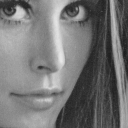

In [99]:
Image.fromarray(mainblocks[10][0], 'L')


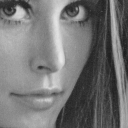

In [100]:
Image.fromarray(combinedMainBlocks[10][0], 'L')


In [101]:
(combinedMainBlocks == mainblocks).all()


False

In [102]:
combinedImg = combineBlocks(combinedMainBlocks.copy(), imgSize, mainblockSize)
combinedImg.shape, combinedImg
combinedImg = combinedImg.reshape(imgSize)
combinedImg.shape, combinedImg


((512, 512),
 array([[162, 161, 163, ..., 170, 155, 128],
        [162, 161, 163, ..., 170, 155, 128],
        [160, 161, 160, ..., 170, 155, 128],
        ...,
        [ 43,  43,  50, ..., 104, 100,  98],
        [ 44,  44,  55, ..., 104, 105, 108],
        [ 44,  44,  55, ..., 104, 105, 108]], dtype=uint8))

In [103]:
(combinedImg == img).all()


False

combining to the image


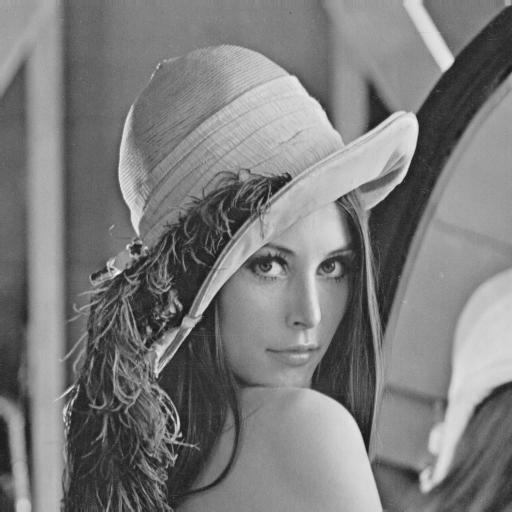

In [104]:
Image.fromarray(combinedImg, 'L')


In [105]:
PSNR(img,combinedImg)


68.40155870980469